# Recruit Restaurant Visitor Forecasting
処理時間：16分<br>
前処理の概要
* 特徴量を作成(日付、店舗のピーク曜日)
* カテゴリ変数を変換(店舗IDと店舗カテゴリ)
* ラグ特徴量(7,14...84日前の来店者数)
* 天気情報を利用、地域は代表的な8都道府県とその他に分類
* 2016/5月と2017/2,3,4月の店舗ごとの平均来店者数を特徴量に追加
* エリア・ジャンルごとの平均来店者数を特徴量に追加
* シフト特徴量を追加
* ラグ特徴量の統計値(主に平均)
* 予約データの利用(airとhpgが紐づけられる150店舗のみ)

Processing time: 16 minutes <br>
Overview of pretreatment
* Create features (date, peak day of the store)
* Convert categorical variables (store ID and store category)
* Rug features (7,14 ... 84 days ago)
* Using weather information, the area is classified into 8 representative prefectures and others
* Added the average number of visitors to each store in May 2016 and February, March, and April 2017 to the features.
* Added the average number of visitors by area and genre to the features
* Added shift features
* Statistics of lag features (mainly average)
* Use of reservation data (only 150 stores where air and hpg are linked)
<br><br>
コードを3つに分割しています<br>
The code is divided into three<br>
https://www.kaggle.com/mnthasi/recruit-restaurant-01-pre
https://www.kaggle.com/mnthasi/recruit-restaurant-02-lightgbm-japanese
https://www.kaggle.com/mnthasi/recruit-restaurant-03-ensemble-japanese
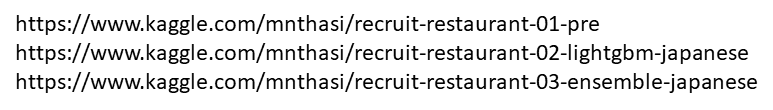
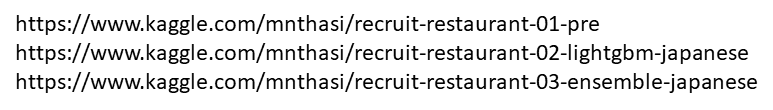
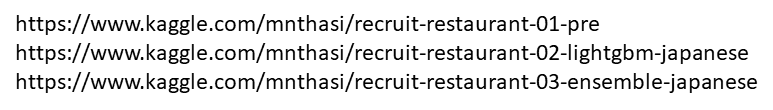
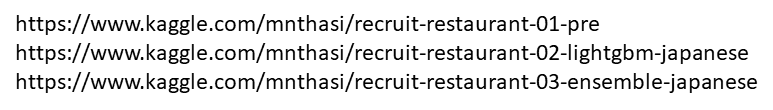

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
train = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/air_visit_data.csv")
date_info = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/date_info.csv")
test = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv")

date_info = date_info.rename(columns={'calendar_date': "visit_date"})
# 日付と店舗の組み合わせを作るときに使うダミー変数
date_info["dammy"] = "dammy"
date_info

# testセットのidの処理

In [ ]:
def back_store_name(txt):
    id = txt
    #_区切りで右から1番目の文字を切り分ける
    txt_split = txt.rsplit("_",1)
    # 切り分けた文字列のうち、0番目を返す
    return txt_split[0]

def back_date_name(txt):
    id = txt
    txt_split = txt.rsplit("_",1)
    return txt_split[1]

#新しい列の名前 = 引数として関数に入れて処理する列の名前
test.loc[:,"air_store_id"] = test["id"].apply(back_store_name)
test.loc[:,"visit_date"] = test["id"].apply(back_date_name)
# test = test.drop(columns = "id")
test

# testとtrainを合体

In [ ]:
data_all = pd.concat([train,test])

In [ ]:
data_all

# ラベルエンコーディング

In [ ]:
from sklearn.preprocessing import LabelEncoder #Library for LabelEncoding

data_all_le = pd.DataFrame()
data_all_le["air_store_id"] = data_all["air_store_id"]
le_unique = data_all_le.air_store_id.unique()

data_all_le_unique = pd.DataFrame(data=le_unique)
data_all_le_unique.columns = ["air_store_id_enc"]

data_all_le_unique_before = data_all_le_unique["air_store_id_enc"]
data_all_le_unique_before = pd.DataFrame(data_all_le_unique_before)
data_all_le_unique_before.columns = ["air_store_id"]

data_all_le_unique

In [ ]:
for c in data_all_le_unique:
    le = LabelEncoder()
    le.fit(data_all_le_unique[c])
    data_all_le_unique[c] = le.transform(data_all_le_unique[c])

# ラベルエンコーディング前後の比較
data_all_le_unique = data_all_le_unique.join(data_all_le_unique_before)
data_all_le_unique

# 店舗情報を持つstore_infoの定義

In [ ]:
store_info =  data_all_le_unique.rename(columns={'air_store_id': 'air_store_id_moto'})
store_info = store_info.rename(columns={'air_store_id_enc': 'air_store_id'})
# 日付と店舗の組み合わせを作るときに使うダミー変数
store_info["dammy"] = "dammy"
store_info

# air_store_info.csvを利用

In [ ]:
air_store_info = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/air_store_info.csv")
genre_le = pd.DataFrame()
genre_le["air_genre_name"] = air_store_info.air_genre_name
area_le = pd.DataFrame()
area_le["air_area_name"] = air_store_info.air_area_name
area_le

In [ ]:
# 頻度の高い順に店舗の名称を出す
unique_area = area_le.air_area_name.value_counts()
u_area_df = pd.DataFrame(unique_area)
u_area_df.head(20)

# 都道府県情報を残しておく
(あとで気象情報と紐づけたい)

In [ ]:
import re
def area2group2(area):
    if re.match(r'Tōkyō.*',area) !=None:
        return 0
    if re.match(r'Ōsaka.*',area) !=None:
        return 1
    if re.match(r'Hokkaidō.*',area) !=None:
        return 2    
    if re.match(r'Fukuoka.*',area) !=None:
        return 3
    if re.match(r'Niigata.*',area) !=None:
        return 4
    if re.match(r'Hiroshima.*',area) !=None:
        return 5
    if re.match(r'Shizuoka.*',area) !=None:
        return 6
    if re.match(r'Miyagi.*',area) !=None:
        return 7
    else:
        return -1

warea = [area2group2(area) for area in area_le.air_area_name]
area_le['area_cluster'] = warea

In [ ]:
# area_le.loc[(area_le.area_cluster==8),"area_cluster"] = -1
area_le.loc[(area_le['area_cluster'] ==8), 'area_cluster'] = -1
area_le

In [ ]:
area_le.loc[176]

In [ ]:
area_le.loc[(area_le.area_cluster==8)]

In [ ]:
area_le_cluster = area_le.area_cluster
area_le_cluster_df = pd.DataFrame(area_le_cluster)
area_le = area_le.drop(columns="area_cluster")

In [ ]:
# ジャンルのラベルエンコーディング
for c in genre_le:
    le_g = LabelEncoder()
    le_g.fit(genre_le[c])
    genre_le[c] = le_g.transform(genre_le[c])

#エリアのラベルエンコーディング
for c in area_le:
    le_a = LabelEncoder()
    le_a.fit(area_le[c])
    area_le[c] = le_a.transform(area_le[c])

In [ ]:
area_le

In [ ]:
area_le = area_le.join(area_le_cluster_df)

In [ ]:
area_le

In [ ]:
air_store_info_genre = pd.DataFrame()
air_store_info_genre["id"] = air_store_info.air_genre_name
air_store_info_genre = air_store_info_genre.join(genre_le)

# ラベルエンコーディングした特徴量を結合
air_store_info = air_store_info.drop(columns = "air_genre_name")
air_store_info = air_store_info.join(genre_le)
air_store_info = air_store_info.drop(columns = "air_area_name")
air_store_info = air_store_info.join(area_le)
# 最も来店者の多い曜日情報と結合するためにソートしindexをつけなおす
air_store_info = air_store_info.sort_values(by='air_store_id')
# indexをつけなおす
air_store_info = air_store_info.reset_index(drop=True)
air_store_info = air_store_info.rename(columns={'air_store_id': 'air_store_id_moto'})
air_store_info

In [ ]:
air_store_info_genre

# ラベルエンコーディング後のIDとジャンル名の対応表

In [ ]:
s_id = air_store_info_genre.id.value_counts()
s_genre = air_store_info_genre.air_genre_name.value_counts()
s_id_df = pd.DataFrame(s_id)
s_id_df = s_id_df.reset_index(drop=False)
s_id_df = s_id_df.drop(columns='id')
s_genre_df= pd.DataFrame(s_genre)
s_genre_df = s_genre_df.reset_index(drop=False)
s_genre_df.columns = ["store_id_le","frequency"]
s_id_genre_df = s_id_df.join(s_genre_df)
s_id_genre_df

In [ ]:
store_info = pd.merge(air_store_info, store_info, on="air_store_id_moto",how="outer")
store_info

# 店舗情報にラベルエンコーディングした店舗IDを紐づけ

In [ ]:
data_all = pd.merge(data_all, data_all_le_unique, on="air_store_id",how="inner")
data_all = data_all.drop(columns = "air_store_id")
data_all = data_all.rename(columns={'air_store_id_enc': 'air_store_id'})
data_all

# 日付×店舗の組み合わせを全部用意する
2016/1/1において、すべての店舗での各日付における来店者数を持つ<br>
DataFrame data_allを作成する<br>
このタイミングで、store_info(air_store_info.csvの情報を含む)を結合する

In [ ]:
# 日にちのユニークバリュー(517日)×店舗のユニークバリュー(829店舗)のデータを用意
data_all_date = pd.merge(date_info, store_info, on=["dammy"],how="outer")

# 複数キーを使ったマージで日付、店舗ごとに来店者数をマージ
data_all = pd.merge(data_all_date, data_all, on=["air_store_id","visit_date"],how="outer")
data_all = data_all.fillna(0)

data_all

In [ ]:
# data_allのvisitorsが200を超える場合は0にする
data_all.loc[data_all["visitors"] > 200, "visitors"] = 0

In [ ]:
data_all

# year,month,dayの列を作成

In [ ]:
# 2017-04-18	
def back_year(txt):
    visit_date = txt
    txt_split = txt.rsplit("-",2)
    return txt_split[0]

def back_month(txt):
    visit_date = txt
    txt_split = txt.rsplit("-",2)
    #04月のような記述にならないように、int型で返す
    return int(txt_split[1])

def back_day(txt):
    visit_date = txt
    txt_split = txt.rsplit("-",2)
    return int(txt_split[2])

data_all.loc[:,"year"] = data_all["visit_date"].apply(back_year)
data_all.loc[:,"month"] = data_all["visit_date"].apply(back_month)
data_all.loc[:,"day"] = data_all["visit_date"].apply(back_day)
data_all

In [ ]:
columns_drop = ["air_store_id_moto","dammy"] 
data_all = data_all.drop(columns = columns_drop)

# 曜日を数字に変換

In [ ]:
# 下記のような変換ルールで置換
def back_downum(txt):
    day_of_week= txt
    day_of_week = txt.replace("Monday","1")
    day_of_week = day_of_week.replace("Tuesday","2")
    day_of_week = day_of_week.replace("Wednesday","3")
    day_of_week = day_of_week.replace("Thursday","4")
    day_of_week = day_of_week.replace("Friday","5")
    day_of_week = day_of_week.replace("Saturday","6")
    day_of_week = day_of_week.replace("Sunday","7")
#     day_of_week = int(day_of_week)
    return day_of_week

data_all.loc[:,"day_of_week"] = data_all["day_of_week"].apply(back_downum)
data_all["day_of_week"] = data_all.day_of_week.astype('int64')
data_all

# データ型を変更

In [ ]:
data_all["year"] = data_all.year.astype('int64')
data_all["visitors"] = data_all.visitors.astype('int64')
data_all

# 気象データのインポート

In [ ]:
weatherData = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/WeatherData.csv")
weatherData.to_csv("weatherData.csv", index=False)
# 気象データを利用
le_wether = weatherData.area_name
le_wether_df = pd.DataFrame(le_wether)
le_wether_df = le_wether_df.rename(columns={'area_name': 'air_area_name'})
le_wether_df["tag"] = "weather"
le_wether_df

In [ ]:
weatherData = weatherData.rename(columns={'area_name': 'air_area_name'})

In [ ]:
weatherData = weatherData.rename(columns={'calendar_date': 'visit_date'})

# 代表的な都道府県ごとにエリア分け

In [ ]:

def area2group(area):
    if re.match(r'tokyo.*',area) !=None:
        return 0
    if re.match(r'osaka.*',area) !=None:
        return 1
    if re.match(r'hokkaido.*',area) !=None:
        return 2    
    if re.match(r'fukuoka.*',area) !=None:
        return 3
    if re.match(r'niigata.*',area) !=None:
        return 4
    if re.match(r'hiroshima.*',area) !=None:
        return 5
    if re.match(r'shizuoka.*',area) !=None:
        return 6
    if re.match(r'miyagi.*',area) !=None:
        return 7
    else:
        return -1

warea = [area2group(area) for area in weatherData.air_area_name]
weatherData['area_cluster'] = warea
weatherData

In [ ]:
# 欠損の多い情報は落とす
weatherData = weatherData.drop(['avg_vapor_pressure', 'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',"solar_radiation","cloud_cover","deepest_snowfall","total_snowfall"], axis=1)
weatherData

In [ ]:
# 日付情報に変換する
weatherData["visit_date"] = pd.to_datetime(weatherData['visit_date'])
weatherData['visit_date'] = weatherData['visit_date'].dt.date
weatherData

# 欠損値の処理
欠損値は0とする

In [ ]:
weatherData["precipitation"] = weatherData["precipitation"].fillna(0)
weatherData["avg_temperature"] = weatherData["avg_temperature"].fillna(0)
weatherData["hours_sunlight"] = weatherData["hours_sunlight"].fillna(0)
weatherData["avg_wind_speed"] = weatherData["avg_wind_speed"].fillna(0)
weatherData["high_temperature"] = weatherData["high_temperature"].fillna(0)
weatherData["low_temperature"] = weatherData["low_temperature"].fillna(0)

# 地域クラスター、日付ごとに平均値をとる
各地域、日付ごとに、気温や降水量の平均をとる。欠損地は0で埋めているので、平均は若干低くなる懸念もある

In [ ]:
# 店舗、曜日ごとのDataFrameを作成する
unique_date = weatherData['visit_date'].unique()
date_df = pd.concat(
    [
        pd.DataFrame({
            'visit_date': unique_date,
            'area_cluster': [i] * len(unique_date)
        }) for i in range(-1,8)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)


#各店舗の来店者数の最大、平均、最頻値、値のカウント
tmp = weatherData.groupby(
    ['visit_date', 'area_cluster'],
    as_index=False)['precipitation'].mean().rename(columns={
        'precipitation': 'mean_precipitation'
    })
date_df = pd.merge(date_df, tmp, how='left', on=['visit_date', 'area_cluster'])

tmp = weatherData.groupby(
    ['visit_date', 'area_cluster'],
    as_index=False)['avg_temperature'].mean().rename(columns={
        'avg_temperature': 'avg_temperature'
    })
date_df = pd.merge(date_df, tmp, how='left', on=['visit_date', 'area_cluster'])

tmp = weatherData.groupby(
    ['visit_date', 'area_cluster'],
    as_index=False)['hours_sunlight'].mean().rename(columns={
        'hours_sunlight': 'mean_hours_sunlight'
    })
date_df = pd.merge(date_df, tmp, how='left', on=['visit_date', 'area_cluster'])

tmp = weatherData.groupby(
    ['visit_date', 'area_cluster'],
    as_index=False)['avg_wind_speed'].mean().rename(columns={
        'avg_wind_speed': 'avg_wind_speed'
    })
date_df = pd.merge(date_df, tmp, how='left', on=['visit_date', 'area_cluster'])

tmp = weatherData.groupby(
    ['visit_date', 'area_cluster'],
    as_index=False)['high_temperature'].mean().rename(columns={
        'high_temperature': 'high_temperature'
    })
date_df = pd.merge(date_df, tmp, how='left', on=['visit_date', 'area_cluster'])

tmp = weatherData.groupby(
    ['visit_date', 'area_cluster'],
    as_index=False)['low_temperature'].mean().rename(columns={
        'low_temperature': 'low_temperature'
    })
date_df = pd.merge(date_df, tmp, how='left', on=['visit_date', 'area_cluster'])

date_df = date_df.reset_index(drop=False)
date_df.to_csv("date_df.csv", index=False)
date_df

# data_allの日付一覧を作る

In [ ]:
data_all_unique = data_all['visit_date'].unique()
data_all_unique = pd.DataFrame(data_all_unique)
data_all_unique.columns = ["visit_date"]

data_all_unique_all = pd.DataFrame()
data_all_unique_all = pd.concat([data_all_unique,data_all_unique,
                                 data_all_unique,data_all_unique,
                                 data_all_unique,data_all_unique,
                                 data_all_unique,data_all_unique,
                                 data_all_unique])

data_all_unique_all = data_all_unique_all.reset_index(drop=False)
data_all_unique_all = data_all_unique_all.drop(columns="index")

data_all_unique_all = data_all_unique_all.reset_index(drop=False)
data_all_unique_all.to_csv("data_all_unique_all.csv", index=False)
data_all_unique_all

In [ ]:
date_df_merge = pd.merge(date_df, data_all_unique_all, on="index")

# 名前を修正する
date_df_merge = date_df_merge.rename(columns={'visit_date_d': 'visit_date'})
date_df_merge = date_df_merge.rename(columns={'visit_date_y': 'visit_date'})
date_df_merge

# 日付情報を追加
visit_dateをキーにしてマージしようとしたがなぜかできなかったので
visit_dateをday,year,monthにわけて、これらをキーにしてマージする

In [ ]:
date_df_merge.loc[:,"year"] = date_df_merge["visit_date"].apply(back_year)
date_df_merge.loc[:,"month"] = date_df_merge["visit_date"].apply(back_month)
date_df_merge.loc[:,"day"] = date_df_merge["visit_date"].apply(back_day)

date_df_merge["year"] = date_df_merge.year.astype('int64')

date_df_merge

# data_allに気象データをマージ

In [ ]:
# 気象情報をマージ
data_all = pd.merge(data_all,date_df_merge,
                    on=["year","month","day","area_cluster"],
                    how="outer")
data_all

In [ ]:
data_all = data_all.drop(columns = "visit_date_x")
data_all = data_all.rename(columns={'visit_date_y': 'visit_date'})

In [ ]:
data_all

# 各店舗の曜日・店ごとの来店者数のまとめ

In [ ]:
# str→datetime形式に変換して、日付を日付として扱えるようにする
data_all['visit_date'] = pd.to_datetime(data_all['visit_date'])

data_all.loc[(data_all['visit_date'] <= dt.datetime(2017,4,22)), 'set'] = 'train'

In [ ]:
train_temp = pd.DataFrame()
train_temp = data_all.loc[data_all.set == "train"]

In [ ]:
# 店舗、曜日ごとのDataFrameを作成する
unique_stores = train_temp['air_store_id'].unique()
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'day_of_week': [i] * len(unique_stores)
        }) for i in range(1,8)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)


#各店舗の来店者数の最大、平均、最頻値、値のカウント
tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

stores

In [ ]:
data_all

# 3-4月の店舗・曜日ごとの来店者数のリストを追加
  直近2カ月のデータの店舗ごとの平均値をsubmitすると、それだけでスコアがかなり高いので特徴量として考慮する
  <br>
  統計量のうち、平均以外はスコアを上げる効果が見られなかったのでコメントアウトしている

In [ ]:
train_temp = pd.DataFrame()
train_temp = data_all.loc[data_all.set == "train"]
train_temp3 = data_all.loc[(data_all.year ==2017) & (data_all.month ==3)]
train_temp4 = data_all.loc[(data_all.year ==2017) & (data_all.month ==4)]
train_temp = pd.concat([train_temp3, train_temp4])

In [ ]:
#各店舗の来店者数の最大、平均、最頻値、値のカウント
tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors34'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

# tmp = train_temp.groupby(
#     ['air_store_id', 'day_of_week'],
#     as_index=False)['visitors'].max().rename(columns={
#         'visitors': 'max_visitors34'
#     })
# stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

# tmp = train_temp.groupby(
#     ['air_store_id', 'day_of_week'],
#     as_index=False)['visitors'].median().rename(columns={
#         'visitors': 'median_visitors34'
#     })
# stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

# tmp = train_temp.groupby(
#     ['air_store_id', 'day_of_week'],
#     as_index=False)['visitors'].count().rename(columns={
#         'visitors': 'count_visitors34'
#     })
# stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

stores

# 前年5月の平均来店者数

In [ ]:
train_temp = data_all.loc[data_all.set == "train"]
train_temp5 = data_all.loc[(data_all.year ==2016) & (data_all.month ==5)]
train_temp = train_temp5

#各店舗の来店者数の平均
tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors5'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

# 2月の平均来店者数

In [ ]:
train_temp = data_all.loc[data_all.set == "train"]
train_temp2 = data_all.loc[(data_all.year ==2017) & (data_all.month ==2)]
train_temp = train_temp2

#各店舗の来店者数の平均
tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors2'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

# 3月の平均来店者数

In [ ]:
train_temp = data_all.loc[data_all.set == "train"]
train_temp3 = data_all.loc[(data_all.year ==2017) & (data_all.month ==3)]
train_temp = train_temp3

#各店舗の来店者数の平均
tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors3'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

# 4月の平均来店者数

In [ ]:
train_temp = data_all.loc[data_all.set == "train"]
train_temp4 = data_all.loc[(data_all.year ==2017) & (data_all.month ==4)]
train_temp = train_temp4

#各店舗の来店者数の平均
tmp = train_temp.groupby(
    ['air_store_id', 'day_of_week'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors4'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'day_of_week'])

In [ ]:
stores

# 店ごとの情報をdata_allへマージ

In [ ]:
data_all = pd.merge(data_all, stores, how='left', on=['air_store_id', 'day_of_week'])
data_all

In [ ]:
data_all.set

# エリア・ジャンルごとの平均来店者数
特定のエリアのあるジャンルの店舗の来店者数を見る<br>
つまり、新宿区にあるラーメン屋の平均来店者数をまとめたdateFreameを用意する

In [ ]:
train_temp = pd.DataFrame()
train_temp = data_all.loc[data_all.set == "train"]
train_temp

In [ ]:
# 店舗、曜日ごとのDataFrameを作成する
unique_area = train_temp['air_area_name'].unique()
stores_area = pd.concat(
    [
        pd.DataFrame({
            'air_area_name': unique_area,
            'air_genre_name': [i] * len(unique_area)
        }) for i in range(0,14)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

stores_area

In [ ]:
#各エリア店舗の来店者数の最大、平均、最頻値、値のカウント
tmp = train_temp.groupby(
    ['air_genre_name', 'air_area_name'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'ave_visitors_area_genre'
    })

tmp

In [ ]:
stores_area = pd.merge(stores_area, tmp, how='left', on=['air_genre_name', 'air_area_name'])
stores_area

# 来店者が多い順にソートしてみる
エリア45、ジャンル13が最も平均来店者数が多い

In [ ]:
stores_area.sort_values(by='ave_visitors_area_genre', ascending=False)

In [ ]:
data_all = pd.merge(data_all, stores_area, how='left', on=['air_area_name', 'air_genre_name'])
data_all

# シフト特徴量の作成

In [ ]:
store_visitors = train_temp.groupby(['air_store_id']).visitors.agg([sum,len,max,min])
store_visitors["ave"] = store_visitors["sum"] // store_visitors["len"]
# 来店者数の平均でソート
store_visitors.sort_values(by='ave', ascending=False)

In [ ]:
%%time
store_all_7 = pd.DataFrame()
store_all_14 = pd.DataFrame()
store_all_21 = pd.DataFrame()
store_all_28 = pd.DataFrame()
store_all_35 = pd.DataFrame()
store_all_42 = pd.DataFrame()
store_all_49 = pd.DataFrame()
store_all_56 = pd.DataFrame()
store_all_63 = pd.DataFrame()
store_all_70 = pd.DataFrame()
store_all_77 = pd.DataFrame()
store_all_84 = pd.DataFrame()

for c in range(0,829,1):
    
    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 7日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag7"] = store["visitors"].shift(7).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_7 = pd.concat([store_all_7, store])
    
    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 14日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag14"] = store["visitors"].shift(14).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_14 = pd.concat([store_all_14, store])
    
    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 21日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag21"] = store["visitors"].shift(21).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_21 = pd.concat([store_all_21, store])

    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 28日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag28"] = store["visitors"].shift(28).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_28 = pd.concat([store_all_28, store])
    
    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag35"] = store["visitors"].shift(35).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_35 = pd.concat([store_all_35, store])
    
        # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag42"] = store["visitors"].shift(42).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_42 = pd.concat([store_all_42, store])
    
    
        # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag49"] = store["visitors"].shift(49).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_49 = pd.concat([store_all_49, store])
    
            # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag56"] = store["visitors"].shift(56).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_56 = pd.concat([store_all_56, store])
    
                # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag63"] = store["visitors"].shift(63).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_63 = pd.concat([store_all_63, store])
    
                # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag70"] = store["visitors"].shift(70).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_70 = pd.concat([store_all_70, store])
    
                    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag77"] = store["visitors"].shift(77).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_77 = pd.concat([store_all_77, store])
    
                    # cで指定した店舗idを持つDataFrameを拾ってくる(店舗別にラグ特徴量を得るために)
    store = data_all.loc[data_all.air_store_id == c]
    # 35日前の来店者数を取得
    x_lag = pd.DataFrame()
    x_lag["lag84"] = store["visitors"].shift(84).rolling(window=1).mean()
    store = store.join(x_lag)
    # 欠損値は、その店舗の平均来店者数で埋める
    ave = store_visitors['ave'][c]
    store = store.fillna(ave)
    store_all_84 = pd.concat([store_all_84, store])
    
# 全範囲のデータでやると3minくらいかかる

In [ ]:
# idでソートしなおす
store_all_7 = store_all_7.sort_index()
store_all_14 = store_all_14.sort_index()
store_all_21 = store_all_21.sort_index()
store_all_28 = store_all_28.sort_index()
store_all_35 = store_all_35.sort_index()
store_all_42 = store_all_42.sort_index()
store_all_49 = store_all_49.sort_index()
store_all_56 = store_all_56.sort_index()
store_all_63 = store_all_63.sort_index()
store_all_70 = store_all_70.sort_index()
store_all_77 = store_all_77.sort_index()
store_all_84 = store_all_84.sort_index()
# ラグ特徴量を結合してlag_all
lag_all = pd.DataFrame()
lag_all["lag7"] = store_all_7.lag7
lag_all["lag14"] = store_all_14.lag14
lag_all["lag21"] = store_all_21.lag21
lag_all["lag28"] = store_all_28.lag28
lag_all["lag35"] = store_all_35.lag35
lag_all["lag42"] = store_all_42.lag42
lag_all["lag49"] = store_all_49.lag49
lag_all["lag56"] = store_all_56.lag56
lag_all["lag63"] = store_all_63.lag63
lag_all["lag70"] = store_all_70.lag70
lag_all["lag77"] = store_all_77.lag77
lag_all["lag84"] = store_all_84.lag84

lag_all["air_store_id"] = store_all_7.air_store_id
lag_all["visit_date"] = store_all_7.visit_date
lag_all

# ラグ特徴量を結合

In [ ]:
data_all = pd.merge(data_all,lag_all,on=["air_store_id","visit_date"],how="outer")
data_all

# ラグ特徴量から特徴量を作る
* lag42-84の平均値を入れる
<br>41までは意図的に落としてるものもあるので
* lag42-49
<br>5月のデータは7-14のラグ特徴量はないので、42日以上前のでーたを使う特徴量を増やしてみる


In [ ]:
data_all["lag_mean_42-84"] = (data_all["lag42"]+
                              data_all["lag49"]+
                              data_all["lag56"]+
                              data_all["lag63"]+
                              data_all["lag70"]+
                              data_all["lag77"]+
                              data_all["lag84"])/7

data_all["lag_mean_7-14"] = (data_all["lag7"]+
                             data_all["lag21"])/2

data_all["lag_mean_7-21"] = (data_all["lag7"]+
                             data_all["lag14"]+
                             data_all["lag21"])/3

data_all["lag_mean_7-28"] = (data_all["lag7"]+
                             data_all["lag14"]+
                             data_all["lag14"]+
                             data_all["lag21"])/4


data_all["lag_mean_42-49"] = (data_all["lag42"]+
                              data_all["lag49"])/2


data_all["lag_mean_42-56"] = (data_all["lag42"]+
                              data_all["lag49"]+
                              data_all["lag56"])/3

data_all["lag_mean_42-63"] = (data_all["lag42"]+
                              data_all["lag49"]+
                              data_all["lag56"]+
                              data_all["lag63"])/4

data_all["lag_mean_42-70"] = (data_all["lag42"]+
                              data_all["lag49"]+
                              data_all["lag56"]+
                              data_all["lag63"]+
                              data_all["lag70"])/5

data_all["lag_mean_42-77"] = (data_all["lag42"]+
                              data_all["lag49"]+
                              data_all["lag56"]+
                              data_all["lag63"]+
                              data_all["lag70"]+
                              data_all["lag77"])/6

data_all

In [ ]:
data_all.visit_date

# 予約データの利用

In [ ]:
reserve = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/hpg_reserve.csv")
hpg_store_info = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/hpg_store_info.csv")
store_id_relation = pd.read_csv("../input/recruit-restaurant-visitor-forecasting-data/store_id_relation.csv")

reserve

In [ ]:
reserve_id = pd.merge(reserve, store_id_relation, on=["hpg_store_id"], how = "outer")
# 150店舗ぶんしか変換できるデータがないので、ひとまず今あるものだけ残す
reserve_id = reserve_id.dropna(axis=0)

def back_date_name(txt):
    visit_datetime = txt
    #_区切りで右から1番目の文字を切り分ける
    txt_split = txt.rsplit(" ",1)
    # 切り分けた文字列のうち、0番目を返す
    return txt_split[0]


reserve_id.loc[:,"visit_date"] = reserve_id["visit_datetime"].apply(back_date_name)
reserve_id.loc[:,"reserve_date"] = reserve_id["reserve_datetime"].apply(back_date_name)

reserve_id = reserve_id.drop(columns = "visit_datetime")
reserve_id = reserve_id.drop(columns = "reserve_datetime")
reserve_id = reserve_id.drop(columns = "hpg_store_id")
reserve_id

In [ ]:
store_id_relation

In [ ]:
hpg_store_info

# 予約データのラベルエンコーディング

In [ ]:
reserve_id = pd.merge(reserve_id, data_all_le_unique, on=["air_store_id"], how="inner")
reserve_id = reserve_id.drop(columns = "air_store_id")
# 名前変更
reserve_id = reserve_id.rename(columns={'air_store_id_enc': 'air_store_id'})
reserve_id

In [ ]:
reserve_id.air_store_id.unique()

In [ ]:
reserve_id.visit_date

# reserve_idのvisit_dateがdtype: datetime64[ns]になってないので変換が必要

In [ ]:
reserve_id.visit_date = pd.to_datetime(reserve_id['visit_date'])
reserve_id.visit_date

In [ ]:
# 予約データのdata_allへマージ
data_all = pd.merge(data_all, reserve_id, on=["air_store_id","visit_date"], how="outer")
data_all = data_all.drop(columns = "reserve_date")
data_all

In [ ]:
# 全てのラベルをnot-testで埋める
data_all['set'] = 'not-test'

# 特徴量をドロップ
精度に悪影響を及ぼす特徴量を落とす

In [ ]:
data_all = data_all.drop(['lag77', 'lag84'], axis=1)
# data_all = data_all.drop(['max_visitors34','median_visitors34','count_visitors34'], axis=1)

In [ ]:
data_all

In [ ]:
for col in data_all:
    print(col)

# もととなるデータを保存

In [ ]:
data_all.to_csv("data_all.csv", index=False)

# 以上、特徴量エンジニアリングは終了
